# Software Implementation of the SDM

In [455]:
# here import libraries needed
import pandas as pd 
#import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib as mpl
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import math

In [456]:
# here load the model with the given initial values and parameters given the point chosen in the model space


##################
# initial values #
##################

R = [1.1]
polarization = [ (R[0] - 1.2 + 8 * 0.2 /(8 - m)) * (8 - m) / 0.2 ] # the first value of polar. is therefore 6 

# scenarios for variables of interest regarding the research questions
gcs = [0.5]
gcq = [0.5] 


#####################
## parameter space ##
#####################

# rate of self-regulation of Polarization 
b = 0.02

# effect of communication strength on polarization
c = 1/6

# effect of communication quality on polarization
e = 0.65

# effect of R on communication strength
i = 0.1

#Sources of parametric uncertainty
#Value at which polarization starts growing instead of decreasing
a = 6.5 # between 6% and 7%
# polarization value at which R = 1
m = 4 # between 3% and 5%


##################
## model space ##
#################

l = 1 # switch for the causal link between polarization and comm quality . When 0 it is on. When 1 it is off
n = 0.05 # determines the influence of polarization on communication quality when the switch is on

In [457]:
# Run here the model for a given number of weeks

num_weeks = 100 # roughly two years of pandemic

for t in range(num_weeks):
    
    # compute polarization
    self_regulation =  (polarization[t] - a) * b 
    depolarization_quality = c * gcq[t] 
    amplification_strength = e * gcs[t]
    p = polarization[t] + (self_regulation - depolarization_quality * amplification_strength) * (12 - polarization[t])/12
    if p > 12:
        p = 12
    elif p < 0:
        p = 0
    polarization.append(p)
    
    # compute R
    r = polarization[t] * 0.2 / (8 - m) + 1.2 - 8 * 0.2 /(8 - m)
    R.append(r)
    
    # compute gcs
    gov_com_strength = gcs[t] + ((R[t] - 1) * i ) * (1 - gcs[t])/1
    if gov_com_strength > 6:
        gov_com_strength = 6
    elif gov_com_strength < 0:
        gov_com_strength = 0
    gcs.append(gov_com_strength)
    
    # compute gcq
    gov_com_quality = gcq[t] - l * n * (1 / (1 + math.e ** (- polarization[t] + 6))) * (1 - abs(gcq[t])) / 1
    if gov_com_quality > 1:
        gov_com_quality = 1
    elif gov_com_quality < - 1:
        gov_com_quality = -1
    gcq.append(gov_com_quality)
    
# convert results in pandas dataframe
dict = {"week": range(num_weeks + 1), "Polarization": polarization, "R": R , "GCS": gcs, "GCQ": gcq}
results = pd.DataFrame(dict)

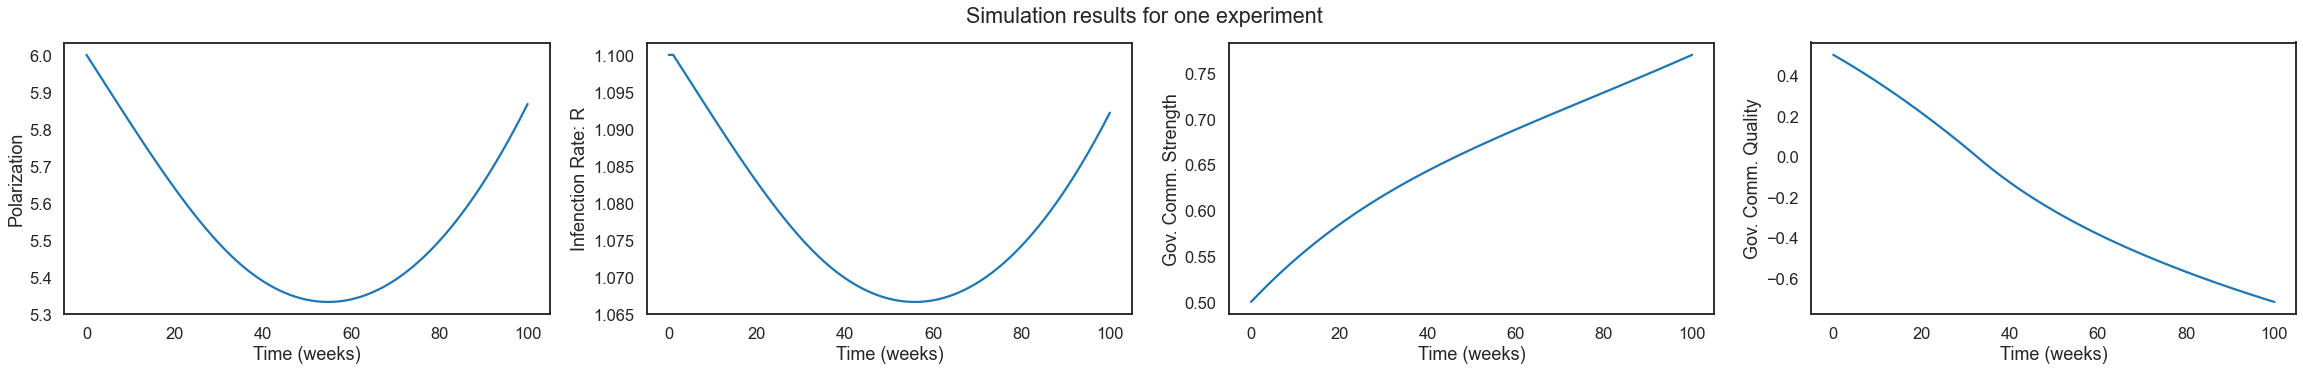

In [458]:
# here plot the results of each model run for verification purposes 

#palette=sns.color_palette("flare", as_cmap=True)
fig, ax =plt.subplots(1,4)
sns.lineplot(data=results, x="week", y="Polarization", ax=ax[0])
sns.lineplot(data=results, x="week", y="R", ax=ax[1])
sns.lineplot(data=results, x="week", y="GCS",  ax=ax[2])
sns.lineplot(data=results, x="week", y="GCQ",  ax=ax[3])

#ensure consistency across pictures and make it pretty
fig.set_size_inches(40, 5)
    
ax[0].set_ylabel('Polarization')
ax[0].set_xlabel('Time (weeks)')
ax[1].set_ylabel('Infenction Rate: R')
ax[1].set_xlabel('Time (weeks)')
ax[2].set_ylabel('Gov. Comm. Strength')
ax[2].set_xlabel('Time (weeks)')
ax[3].set_ylabel('Gov. Comm. Quality')
ax[3].set_xlabel('Time (weeks)')

plt.suptitle('Simulation results for one experiment')
plt.show()

# Model estimation and uncertainty quantification


## Model estimation
The parameters were estimated manually to obtain system's behaviour that would display plaudisle patterns. 

In terms of a "cost function" all variable of the joint parameter and model space were considered (qualitatively) equally important. Generalizability was not taken into account

The following fixed values for the parameters that are uncertain were considered:  

a = 6.5 (has to be comprised between 6 and 7 %)

m = 4 (has to be comprised between 3 and 5 %)

## Uncertainty Quantification

### Parametric Uncertainty
The uncertain parameters are a and m with uncertainty bounds of 

a between 6 and 7 %

m between 3 and 5 %


### Structural Uncertainty
The causal link between polarization and govermenment communication quality is uncertain, and so is the associated function. 

For simplicity only one functional form was chosen to capture the negative flow of information quality due to polarization. The chosen function is a sigmoidal traslated over the horizontal axis (representing polarization). The goal of such traslation is to have a tipping point after a certain value of the polarization (around 4%).

Distributions of likelihood could not be derived from the expected model output as such data was not available. As such it is assumed that such distibutions are uniform within the given uncertainty bounds. Generalizability was not considered in this case for the same reason. 

# Uncertainty Propagation

In this phase, the structural and parametric uncertainties associated with the model and parameter spaces were propagated to the model output. This was carried out via a quasi-monte carlo approach. 

In [459]:
from SALib.sample import saltelli

In [460]:
problem = {
    # number of parameters in the model
  'num_vars': 5,
    # names of the parameters considered (global variables in netlogo)
  'names': ['initial_gcs',
            'initial_gcq',
            'a',
            'm',
            'l'],
    # experiments bounds in the model
  'bounds': [[0, 1],
             [-1, 1],
             [6, 7],
             [3, 5],
             [0, 1]] # this is here sampled as a continuous variable but then rounded to the nearest integer (trick to sample from discrete distribution)
}

#generates a saltelli sample based on the problem above. 
n =1024
joint_distrib_values = saltelli.sample(problem, n, calc_second_order=True)

#round the values of the switch "l" to the neareast integer
for i in range(len(joint_distrib_values)): 
    joint_distrib_values [i,4] = round(joint_distrib_values [i,4])
    
joint_distrib_values

array([[ 1.46484375e-03, -2.47070312e-01,  6.44775391e+00,
         3.97363281e+00,  1.00000000e+00],
       [ 8.44238281e-01, -2.47070312e-01,  6.44775391e+00,
         3.97363281e+00,  1.00000000e+00],
       [ 1.46484375e-03, -5.16601562e-01,  6.44775391e+00,
         3.97363281e+00,  1.00000000e+00],
       ...,
       [ 6.57714844e-01, -7.64648438e-01,  6.03173828e+00,
         3.70214844e+00,  0.00000000e+00],
       [ 6.57714844e-01, -7.64648438e-01,  6.03173828e+00,
         4.82910156e+00,  1.00000000e+00],
       [ 6.57714844e-01, -7.64648438e-01,  6.03173828e+00,
         4.82910156e+00,  0.00000000e+00]])

In [461]:
# create a function running one model experiment and returing its results

def simulation(experiment_number, experiment): # where experiment is one row of the numpy array of sampled parameter values

    
    #####################
    ## parameter space ##
    #####################

    # rate of self-regulation of Polarization 
    b = 0.02

    # effect of communication strength on polarization
    c = 1/6

    # effect of communication quality on polarization
    e = 0.65

    # effect of R on communication strength
    i = 0.1

    #Sources of parametric uncertainty
    #Value at which polarization starts growing instead of decreasing
    a = experiment[2] # between 6% and 7%
    # polarization value at which R = 1
    m = experiment[3] # between 3% and 5%
    
    
    ##################
    # initial values #
    ##################

    R = [1.1]
    polarization = [ (R[0] - 1.2 + 8 * 0.2 /(8 - m)) * (8 - m) / 0.2 ] # the first value of polar. is therefore 6 

    # scenarios for variables of interest regarding the research questions
    gcs = [experiment[0]]
    gcq = [experiment[1]]

    #################
    ## model space ##
    #################

    l = experiment[4] # switch for the causal link between polarization and comm quality . When 0 it is on. When 1 it is off
    n = 0.05 # determines the influence of polarization on communication quality when the switch is on
    
    ###############
    ## run model ##
    ###############
    results = pd.DataFrame()
    num_weeks = 100 # roughly two years of pandemic
        
    for t in range(num_weeks):

        # compute polarization
        self_regulation =  (polarization[t] - a) * b 
        depolarization_quality = c * gcq[t] 
        amplification_strength = e * gcs[t]
        p = polarization[t] + (self_regulation - depolarization_quality * amplification_strength) * (12 - polarization[t])/12
        if p > 12:
            p = 12
        elif p < 0:
            p = 0
        polarization.append(p)

        # compute R
        r = polarization[t] * 0.2 / (8 - m) + 1.2 - 8 * 0.2 /(8 - m)
        R.append(r)

        # compute gcs
        gov_com_strength = gcs[t] + ((R[t] - 1) * i ) * (1 - gcs[t])/1
        if gov_com_strength > 6:
            gov_com_strength = 6
        elif gov_com_strength < 0:
            gov_com_strength = 0
        gcs.append(gov_com_strength)

        # compute gcq
        gov_com_quality = gcq[t] - l * n * (1 / (1 + math.e ** (- polarization[t] + 6))) * (1 - abs(gcq[t])) / 1
        if gov_com_quality > 1:
            gov_com_quality = 1
        elif gov_com_quality < - 1:
            gov_com_quality = -1
        gcq.append(gov_com_quality)

    # convert results in pandas dataframe
    dict = {"experiment": [experiment_number]*(num_weeks + 1), "week": range(num_weeks + 1), "Polarization": polarization, "R": R , "GCS": gcs, "GCQ": gcq}
    results_experiment = pd.DataFrame(dict)
    
    return results_experiment


In [462]:
# run all the experiments
results = pd.DataFrame()
for i in range(len(joint_distrib_values)): 
    experiment = joint_distrib_values[i]
    results_experiment = simulation(i, experiment)
    results = pd.concat([results, results_experiment], ignore_index = True, axis = 0)
    

In [463]:
results

,experiment,week,Polarization,R,GCS,GCQ
0,0,0,5.986816,1.100000,0.001465,-0.247070
1,0,1,5.982217,1.100000,0.011450,-0.265769
2,0,2,5.977713,1.099772,0.021336,-0.283962
3,0,3,5.973324,1.099548,0.031100,-0.301664
4,0,4,5.969069,1.099330,0.040745,-0.318889
...,...,...,...,...,...,...
1241083,12287,96,9.643066,1.301750,0.949986,-0.764648
1241084,12287,97,9.672708,1.303634,0.951495,-0.764648
1241085,12287,98,9.702117,1.305504,0.952968,-0.764648
1241086,12287,99,9.731291,1.307359,0.954405,-0.764648


In [464]:
# at each time step compute 5th and 95th percentiles and median and save it into a new pandas dataframe
results_percentiles = pd.DataFrame()
for i in range(len(joint_distrib_values)):
    results_one_timestep = results.loc[(results["week"] == i), ["Polarization", "R", "GCS", "GCQ"]]
    percentiles_one_timestep = results_one_timestep.quantile ([0.05, 0.5, 0.95]) 
    percentiles_row = pd.DataFrame({
                    'week': [i],
                    'polarization_5': [percentiles_one_timestep.loc[0.05, ["Polarization"]].values[0]],
                    'polarization_median': [percentiles_one_timestep.loc[0.50, ["Polarization"]].values[0]],
                    'polarization_95': [percentiles_one_timestep.loc[0.95, ["Polarization"]].values[0]],
                    'R_5': [percentiles_one_timestep.loc[0.05, ["R"]].values[0]],
                    'R_median': [percentiles_one_timestep.loc[0.50, ["R"]].values[0]],
                    'R_95': [percentiles_one_timestep.loc[0.95, ["R"]].values[0]],
                    'GCS_5': [percentiles_one_timestep.loc[0.05, ["GCS"]].values[0]],
                    'GCS_median': [percentiles_one_timestep.loc[0.50, ["GCS"]].values[0]],
                    'GCS_95': [percentiles_one_timestep.loc[0.95, ["GCS"]].values[0]],
                    'GCQ_5': [percentiles_one_timestep.loc[0.05, ["GCQ"]].values[0]],
                    'GCQ_median': [percentiles_one_timestep.loc[0.50, ["GCQ"]].values[0]],
                    'GCQ_95': [percentiles_one_timestep.loc[0.95, ["GCQ"]].values[0]]
    })
    
    results_percentiles= pd.concat([results_percentiles, percentiles_row], ignore_index = True, axis = 0)




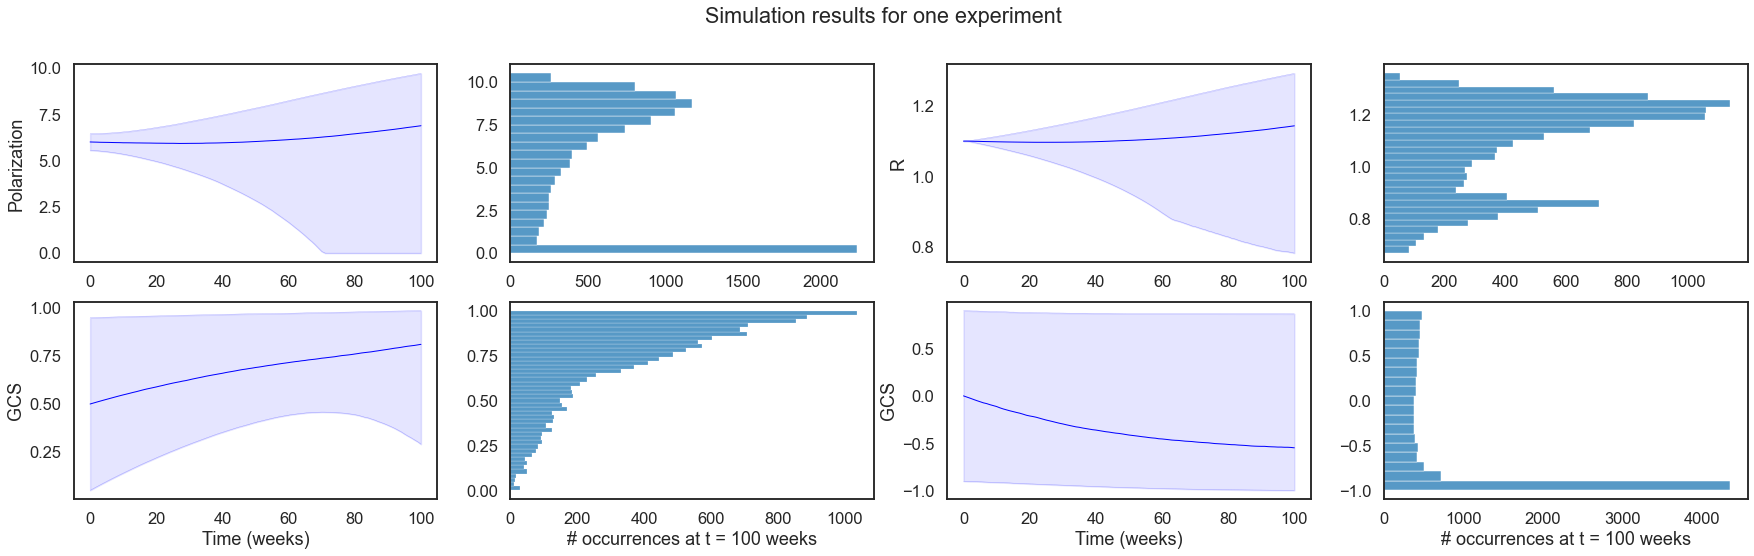

In [465]:
#palette=sns.color_palette("flare", as_cmap=True)
fig, ax =plt.subplots(2,4)

#plot Polarization
color = 'blue'
ax[0,0].plot(results_percentiles.week, results_percentiles.polarization_5, color = color, linewidth=0.3, alpha=0.3)
ax[0,0].plot(results_percentiles.week, results_percentiles.polarization_median, color = color, linewidth=1)
ax[0,0].plot(results_percentiles.week, results_percentiles.polarization_95, color = color, linewidth=0.3, alpha=0.3)
ax[0,0].fill_between(results_percentiles.week, results_percentiles.polarization_5, results_percentiles.polarization_95, color = color, alpha=.1)
results_t = results.loc[(results["week"]==100), ["week", "Polarization"]]
sns.histplot(data = results_t  , y = "Polarization", ax=ax[0,1])

#plot R
color = 'blue'
ax[0,2].plot(results_percentiles.week, results_percentiles.R_5, color = color, linewidth=0.3, alpha=0.3)
ax[0,2].plot(results_percentiles.week, results_percentiles.R_median, color = color, linewidth=1)
ax[0,2].plot(results_percentiles.week, results_percentiles.R_95, color = color, linewidth=0.3, alpha=0.3)
ax[0,2].fill_between(results_percentiles.week, results_percentiles.R_5, results_percentiles.R_95, color = color, alpha=.1)
results_t = results.loc[(results["week"]==100), ["week", "R"]]
sns.histplot(data = results_t  , y = "R", ax=ax[0,3])


#plot GCS
color = 'blue'
ax[1,0].plot(results_percentiles.week, results_percentiles.GCS_5, color = color, linewidth=0.3, alpha=0.3)
ax[1,0].plot(results_percentiles.week, results_percentiles.GCS_median, color = color, linewidth=1)
ax[1,0].plot(results_percentiles.week, results_percentiles.GCS_95, color = color, linewidth=0.3, alpha=0.3)
ax[1,0].fill_between(results_percentiles.week, results_percentiles.GCS_5, results_percentiles.GCS_95, color = color, alpha=.1)
results_t = results.loc[(results["week"]==100), ["week", "GCS"]]
sns.histplot(data = results_t  , y = "GCS", ax=ax[1,1])

#plot GCQ
color = 'blue'
ax[1,2].plot(results_percentiles.week, results_percentiles.GCQ_5, color = color, linewidth=0.3, alpha=0.3)
ax[1,2].plot(results_percentiles.week, results_percentiles.GCQ_median, color = color, linewidth=1)
ax[1,2].plot(results_percentiles.week, results_percentiles.GCQ_95, color = color, linewidth=0.3, alpha=0.3)
ax[1,2].fill_between(results_percentiles.week, results_percentiles.GCQ_5, results_percentiles.GCQ_95, color = color, alpha=.1)
results_t = results.loc[(results["week"]==100), ["week", "GCQ"]]
sns.histplot(data = results_t  , y = "GCQ", ax=ax[1,3])


fig.set_size_inches(30, 8)
    
ax[0,0].set_ylabel('Polarization')
ax[0,0].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel('')

ax[0,2].set_ylabel('R')
ax[0,2].set_xlabel('')
ax[0,3].set_ylabel('')
ax[0,3].set_xlabel('')

ax[1,0].set_ylabel('GCS')
ax[1,0].set_xlabel('Time (weeks)')
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('# occurrences at t = 100 weeks')

ax[1,2].set_ylabel('GCS')
ax[1,2].set_xlabel('Time (weeks)')
ax[1,3].set_ylabel('')
ax[1,3].set_xlabel('# occurrences at t = 100 weeks')

plt.suptitle('Uncertainty propagation on te results')
plt.show()


# Sensitivity Analysis

In [492]:
#using the same sample as above, here run a Sobol sensitivity analysis 

#Import the sampling and analysis modules for a Sobol variance-based sensitivity analysis
from SALib.analyze import sobol
from src.plot import plot_sobol_indices


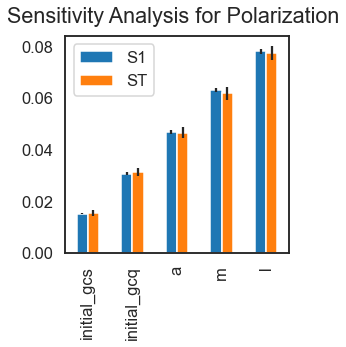

In [493]:
Si = sobol.analyze(problem, results["Polarization"].values, calc_second_order=True, print_to_console=False)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
fig, ax = plt.subplots(1)
indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(4,4)
plt.suptitle('Sensitivity Analysis for Polarization')
plt.show()

Text(0.5, 0.98, 'Sensitivity Analysis for Polarization')

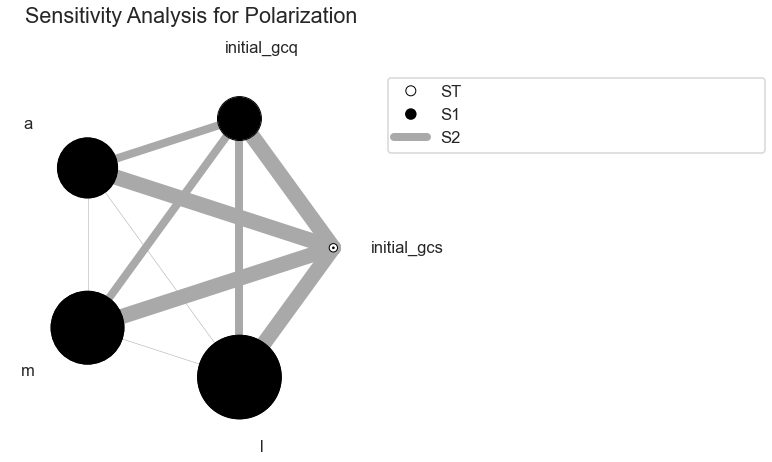

In [494]:
fig = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)
plt.suptitle('Sensitivity Analysis for Polarization')

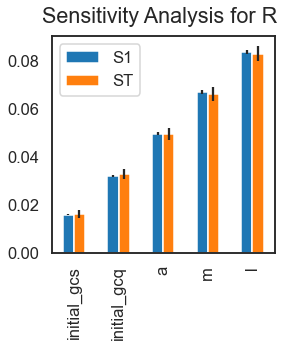

In [498]:
Si = sobol.analyze(problem, results["R"].values, calc_second_order=True, print_to_console=False)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
fig, ax = plt.subplots(1)
indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(4,4)
plt.suptitle('Sensitivity Analysis for R')
plt.show()

Text(0.5, 0.98, 'Sensitivity Analysis for R')

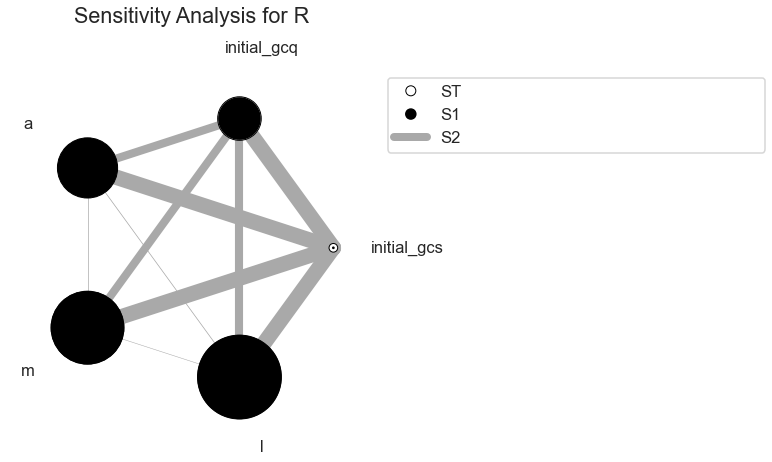

In [499]:
fig = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)
plt.suptitle('Sensitivity Analysis for R')

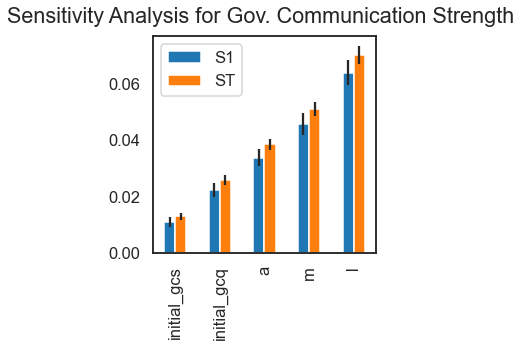

In [500]:
Si = sobol.analyze(problem, results["GCS"].values, calc_second_order=True, print_to_console=False)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
fig, ax = plt.subplots(1)
indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(4,4)
plt.suptitle('Sensitivity Analysis for Gov. Communication Strength')
plt.show()

Text(0.5, 0.98, 'Sensitivity Analysis for Gov. Communication Strength')

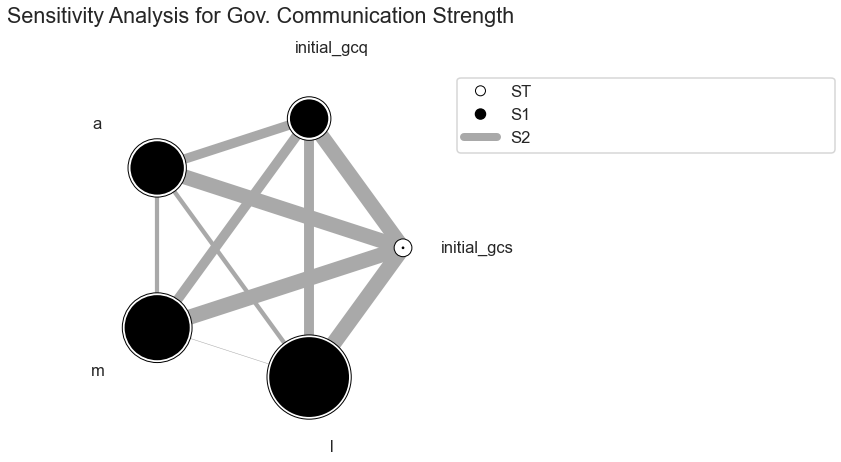

In [501]:
fig = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)
plt.suptitle('Sensitivity Analysis for Gov. Communication Strength')

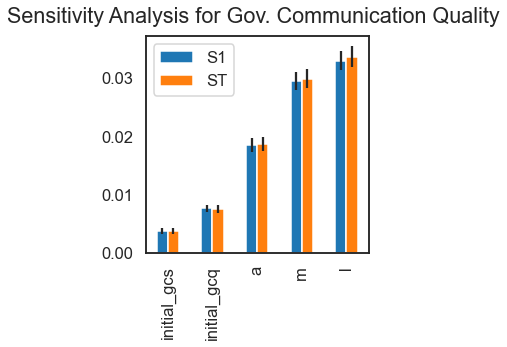

In [502]:
Si = sobol.analyze(problem, results["GCQ"].values, calc_second_order=True, print_to_console=False)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
fig, ax = plt.subplots(1)
indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(4,4)
plt.suptitle('Sensitivity Analysis for Gov. Communication Quality')
plt.show()

Text(0.5, 0.98, 'Sensitivity Analysis for Gov. Communication Quality')

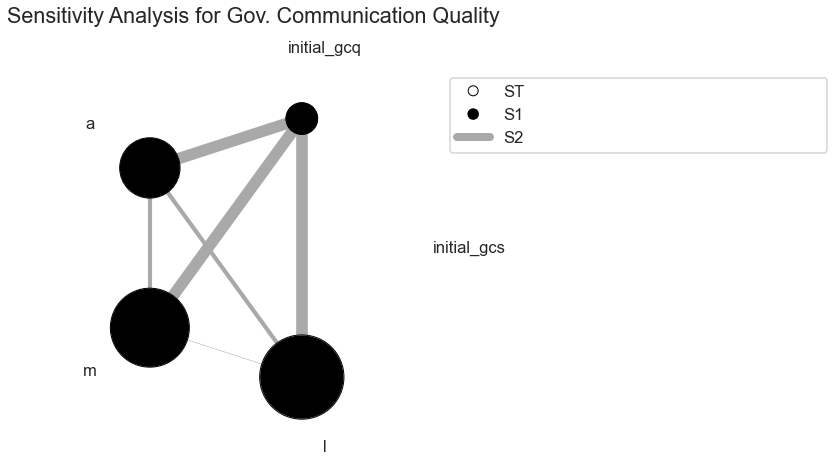

In [503]:
fig = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)
plt.suptitle('Sensitivity Analysis for Gov. Communication Quality')

# Answering research questions

What is the impact of the initial value of government communication strength on the dynamic of the other three variables? 

What is the impact of the initial value of government communicaiton quality on the other three variables? 

for this we could even do hypothesis testing. But I will not do it here due to time constraints. 

Here we use the same results as obtained before based on sampling. 


In [349]:
#Add here some boxplots for all time steps 


In [352]:
#add here a spaghetti graph to have an overiew of the simulation (if not too messy)


## Influence of initial Government Information Quality


In [507]:
# slice results dataframe for results with infomrmation quality =>0 and < 0
results_plusQ = results.loc[(results["GCQ"] >= 0), ["week", "GCQ"]]
results_minusQ = results.loc[(results["GCQ"] < 0), ["week", "GCQ"]]

#calculate the 5% and 95% percentalies for the two
results_percentiles_plusQ = pd.DataFrame()
for i in range(len(joint_distrib_values)): # should make a function of this instead of copying the code everytime
    results_one_timestep = results_plusQ.loc[(results["week"] == i), ["GCQ"]]
    percentiles_one_timestep = results_one_timestep.quantile ([0.05, 0.5, 0.95]) 
    percentiles_row = pd.DataFrame({
                    'week': [i],
                    'GCQ_5': [percentiles_one_timestep.loc[0.05, ["GCQ"]].values[0]],
                    'GCQ_median': [percentiles_one_timestep.loc[0.50, ["GCQ"]].values[0]],
                    'GCQ_95': [percentiles_one_timestep.loc[0.95, ["GCQ"]].values[0]]})
    results_percentiles_plusQ= pd.concat([results_percentiles, percentiles_row], ignore_index = True, axis = 0)

results_percentiles_minusQ = pd.DataFrame()
for i in range(len(joint_distrib_values)):
    results_one_timestep = results_minusQ.loc[(results["week"] == i), ["GCQ"]]
    percentiles_one_timestep = results_one_timestep.quantile ([0.05, 0.5, 0.95]) 
    percentiles_row = pd.DataFrame({
                    'week': [i],
                    'GCQ_5': [percentiles_one_timestep.loc[0.05, ["GCQ"]].values[0]],
                    'GCQ_median': [percentiles_one_timestep.loc[0.50, ["GCQ"]].values[0]],
                    'GCQ_95': [percentiles_one_timestep.loc[0.95, ["GCQ"]].values[0]]})
    results_percentiles_minusQ= pd.concat([results_percentiles, percentiles_row], ignore_index = True, axis = 0)

ValueError: x and y must have same first dimension, but have shapes (12289,) and (12288,)

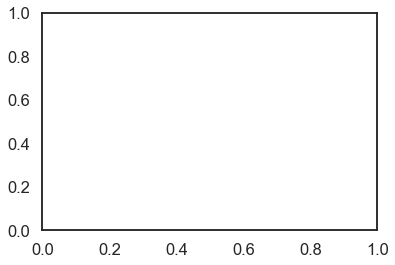

In [508]:
fig, ax =plt.subplots(1,1)

#plot simulations with negative initial quality
color = 'blue'
ax.plot(results_percentiles_minusQ.week, results_percentiles.GCQ_5, color = color, linewidth=0.3, alpha=0.3)
ax.plot(results_percentiles_minusQ.week, results_percentiles.GCQ_median, color = color, linewidth=1)
ax.plot(results_percentiles_minusQ.week, results_percentiles.GCQ_95, color = color, linewidth=0.3, alpha=0.3)
ax.fill_between(results_percentiles_minusQ.week, results_percentiles.GCQ_5, results_percentiles.GCQ_95, color = color, alpha=.1)

#plot simulations with positive initial quality
color = 'blue'
ax.plot(results_percentiles_plusQ.week, results_percentiles.GCQ_5, color = color, linewidth=0.3, alpha=0.3)
ax.plot(results_percentiles_plusQ.week, results_percentiles.GCQ_median, color = color, linewidth=1)
ax.plot(results_percentiles_plusQ.week, results_percentiles.GCQ_95, color = color, linewidth=0.3, alpha=0.3)
ax.fill_between(results_percentiles_minusQ.week, results_percentiles.GCQ_5, results_percentiles.GCQ_95, color = color, alpha=.1)
